In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import regex as re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
from sklearn.ensemble import GradientBoostingRegressor
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

In [2]:
data = pd.read_csv('cleaned_data_barca4.csv')

In [3]:
data.shape

(15063, 65)

In [4]:
data.describe()

,id,host_acceptance_rate,latitude,longitude,bedrooms,price,maximum_nights,availability_30,availability_60,availability_90,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
count,1.506300e+04,15063.000000,15063.000000,15063.000000,15063.000000,15063.000000,15063.00000,15063.000000,15063.000000,15063.000000,...,15061.000000,15063.000000,15062.000000,15063.000000,15063.000000,15063.000000,1.506300e+04,1.506300e+04,15063.000000,15062.000000
mean,4.734309e+17,86.516896,41.392148,2.167091,1.776472,178.680542,532.61588,8.925911,23.514771,42.090287,...,1.280659,2.470932,1.064998,6.586361,44.966369,314.689035,2.724652e+06,7.821143e+09,1.522713,2.322202
std,4.808650e+17,22.912730,0.014000,0.017552,1.100886,152.205068,408.04424,9.218721,19.115914,28.154650,...,0.489644,1.916528,0.703004,1.259492,14.899170,141.632345,4.254139e+06,1.628271e+10,0.130633,0.890505
min,1.867400e+04,0.000000,41.350673,2.091740,0.000000,10.000000,1.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,1.000000
25%,2.904738e+07,85.000000,41.381090,2.156620,1.000000,70.000000,330.00000,1.000000,7.000000,16.000000,...,1.000000,0.693147,1.000000,6.063785,36.769491,222.962296,1.849000e+05,7.950700e+07,1.508512,1.000000
50%,5.660840e+17,98.000000,41.389950,2.168053,1.000000,134.000000,365.00000,6.000000,19.000000,42.000000,...,1.000000,2.397895,1.000000,6.762730,45.734510,309.290123,7.482250e+05,6.472146e+08,1.547563,3.000000
75%,9.500813e+17,100.000000,41.401590,2.177678,2.000000,244.000000,1125.00000,14.000000,40.000000,67.000000,...,2.000000,4.143135,2.000000,7.509883,56.398344,423.544965,3.334276e+06,6.088388e+09,1.574846,3.000000
max,1.178911e+18,100.000000,41.458092,2.227710,18.000000,1060.000000,3000.00000,30.000000,60.000000,90.000000,...,2.000000,7.660114,2.000000,8.534837,72.843436,621.706828,2.589792e+07,1.317945e+11,1.609438,3.000000


In [5]:
data.isnull().sum().loc[lambda x: x > 0]

ln_beds                1753
f_bathroom                2
f_number_of_reviews       1
f_minimum_nights          1
dtype: int64

In [6]:
data['f_bathroom']=data['f_bathroom'].fillna(1)
data['f_minimum_nights']=data['f_minimum_nights'].fillna(1)
data['f_number_of_reviews']=data['f_number_of_reviews'].fillna(1)
data['ln_beds']=data['ln_beds'].fillna(0)

In [7]:
data.flag_days_since.value_counts()

flag_days_since
0    11799
1     3264
Name: count, dtype: int64

In [8]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

## Create new variables measuring the time since: squared, cubic, logs

In [9]:
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
).assign(
    ln_days_since=lambda x: np.where(
        x["ln_days_since"].isnull(), 0, x["ln_days_since"]
    ),
    ln_days_since2=lambda x: np.where(
        x["ln_days_since2"].isnull(), 0, x["ln_days_since2"]
    ),
    ln_days_since3=lambda x: np.where(
        x["ln_days_since3"].isnull(), 0, x["ln_days_since3"]
    ),
)

In [10]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

In [11]:
data['n_accommodates'].describe()

count    15063.000000
mean         3.527850
std          2.091393
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: n_accommodates, dtype: float64

In [12]:
data = data.loc[data.n_accommodates < 8]

In [13]:
data.groupby(["room_type"]).agg(mean_price=("price", np.mean))


,mean_price
room_type,
Entire home/apt,201.273963
Hotel room,273.774194
Private room,90.387492
Shared room,81.609091


In [14]:
data.price.describe()

count    14319.000000
mean       164.635729
std        133.469869
min         10.000000
25%         68.000000
50%        126.000000
75%        228.000000
max       1000.000000
Name: price, dtype: float64

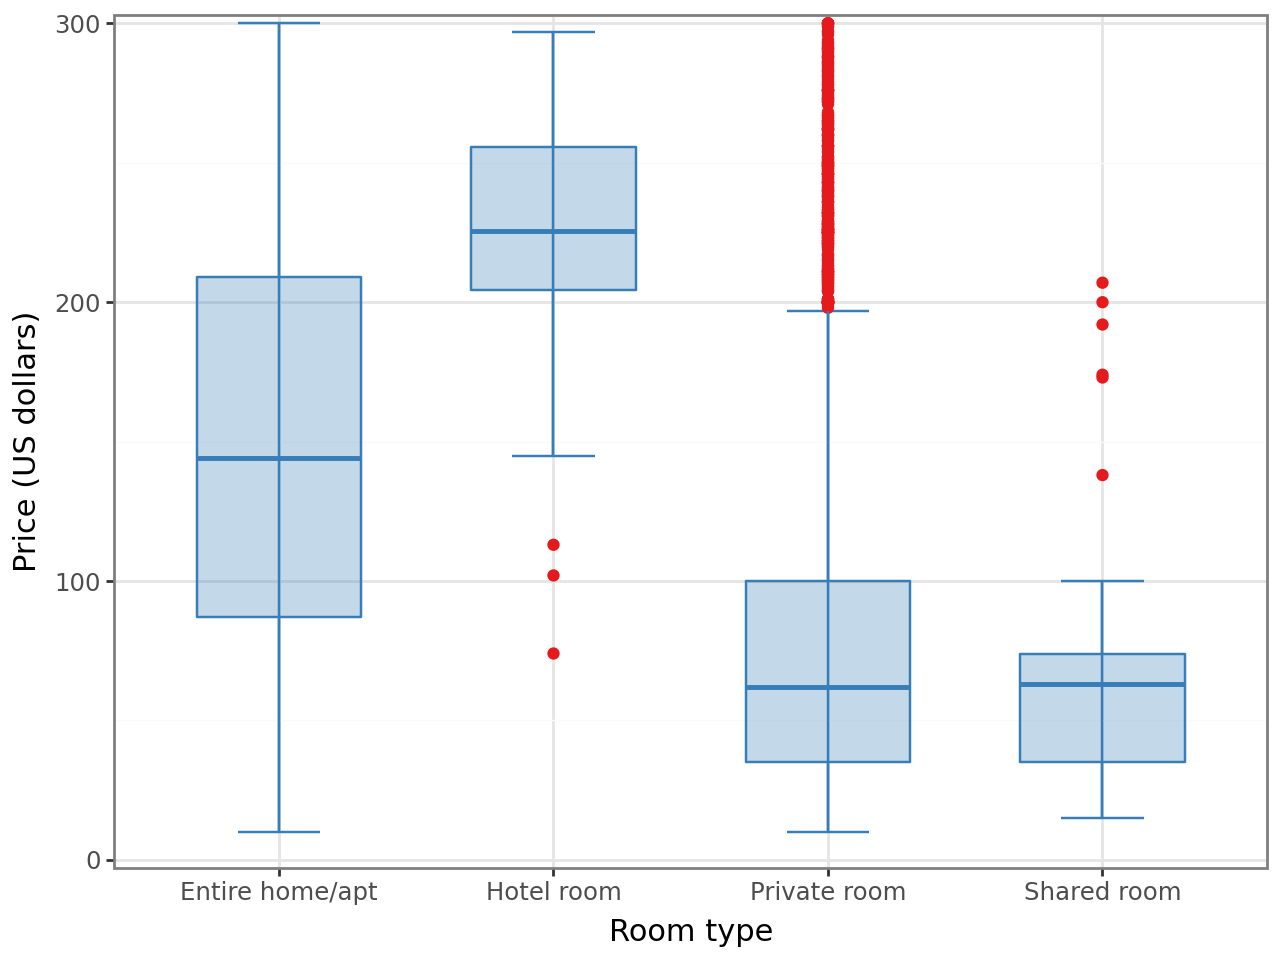

In [15]:
# Define the colors (replace with actual color values)
color = ["#E41A1C", "#377EB8", "#4DAF4A"]

# Define the plot
plot = (
    ggplot(data, aes(x="room_type", y="price"))
    + stat_boxplot(
        aes(group="room_type"),
        geom="errorbar",
        width=0.3,
        color=color[1],  # Adjusted to a valid color format
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="room_type"),
        color=color[1],  # Boxplot border color
        fill=color[1],  # Boxplot fill color
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_color=color[0],  # Specify a valid color instead of an empty string
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=np.arange(0, 301, 100))
    + labs(x="Room type", y="Price (US dollars)")
    + theme_bw()
)

# Display the plot
print(plot)


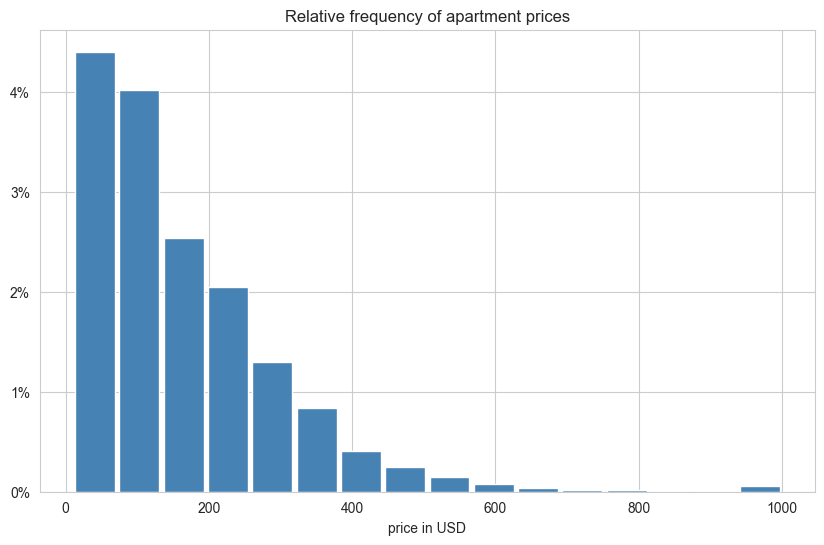

In [16]:
# relative frequencies with matplotlib

from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(data.price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
ax.set_xlabel('price in USD')
# ax.grid()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1, decimals = 0))
ax.set_title('Relative frequency of apartment prices')
plt.show()

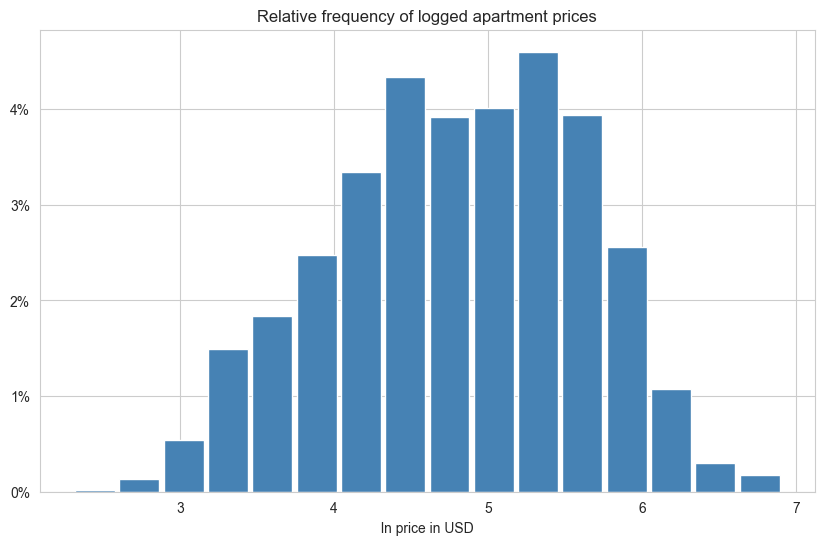

In [17]:
# relative frequencies with matplotlib
from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(data.ln_price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
# ax.set_xticks(range(0, df.price.max(), 2000))
ax.set_xlabel('ln price in USD')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=10, decimals = 0))
ax.set_title('Relative frequency of logged apartment prices')
plt.show()

In [18]:
data["room_type"] = pd.Categorical(
    data["room_type"], categories=sorted(set(data["room_type"]), reverse=False)
)

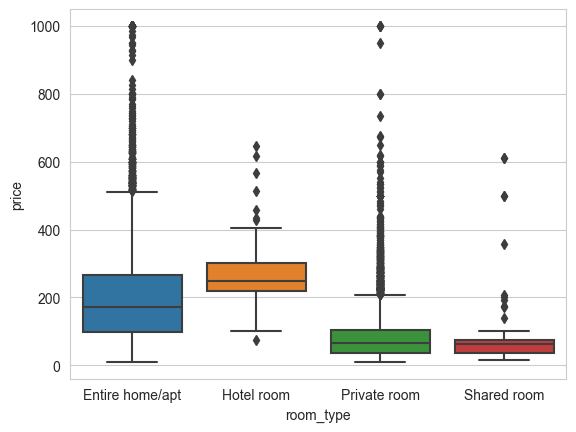

In [19]:
sns.boxplot(data = data, x = 'room_type', y = 'price', orient = 'v', order = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'])
plt.show()

In [20]:
data.room_type.value_counts()

room_type
Entire home/apt    9494
Private room       4653
Shared room         110
Hotel room           62
Name: count, dtype: int64

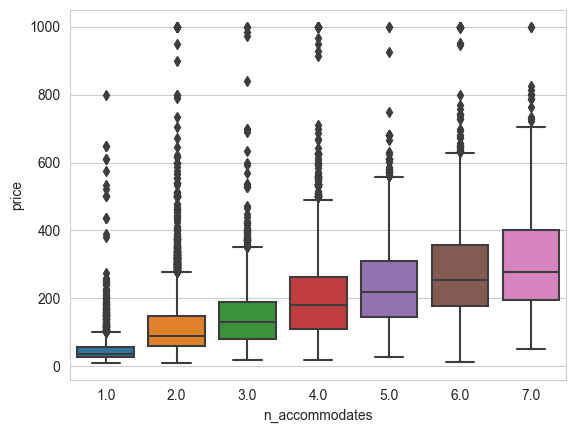

In [21]:
sns.boxplot(data = data, x = 'n_accommodates', y = 'price', orient = 'v')
plt.show()

In [22]:
data.n_accommodates.value_counts().sort_index()

n_accommodates
1.0    2050
2.0    4312
3.0    1407
4.0    3401
5.0    1347
6.0    1509
7.0     293
Name: count, dtype: int64

# Part 2. Setting up models

In [23]:
basic_lev = ( "n_accommodates",
    "n_beds",
    "room_type",
    "n_days_since",
    "flag_days_since",
    "f_bathroom",
     "distance")

host = ("host_acceptance_rate",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified")

amenities = (
    "Laundry",
    "Essentials",
    "Heating_Cooling",
    "Kitchen",
    "Outdoor",
    "Workspace",
    "Entertainment",
    "Luxury",
    "Internet",
    "Parking",
    "Family"
)

nights = ( "n_minimum_nights", "maximum_nights") 
reviews = ("f_number_of_reviews", "n_review_scores_rating", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")


In [24]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c  # Distance in kilometers
    return distance

city_center_lat = 41.3874 # Barcelona coordinates
city_center_lon = 2.1686

In [25]:
data['distance'] = data.apply(
    lambda row: haversine(row['latitude'], row['longitude'], city_center_lat, city_center_lon),
    axis=1
)

In [26]:
data['in_center'] = (data['distance'] <= 2).astype(int)

## Interactions

In [27]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt

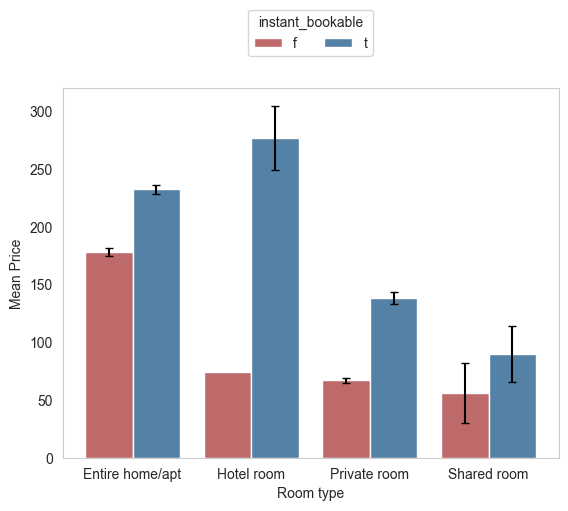

<module 'matplotlib.pyplot' from 'C:\\Users\\Acer\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [28]:
price_diff_by_variables(data, "room_type", 'instant_bookable', "Room type", 'instant_bookable')

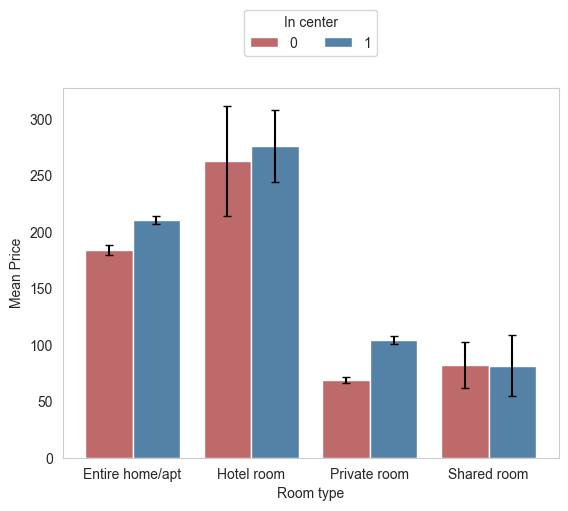

<module 'matplotlib.pyplot' from 'C:\\Users\\Acer\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [29]:
price_diff_by_variables(data, "room_type", 'in_center', "Room type", 'In center')

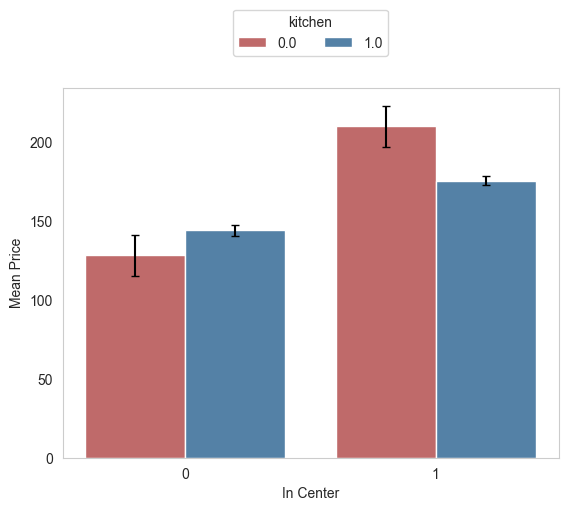

In [30]:
price_diff_by_variables(data, "in_center", "Kitchen", "In Center", "kitchen");

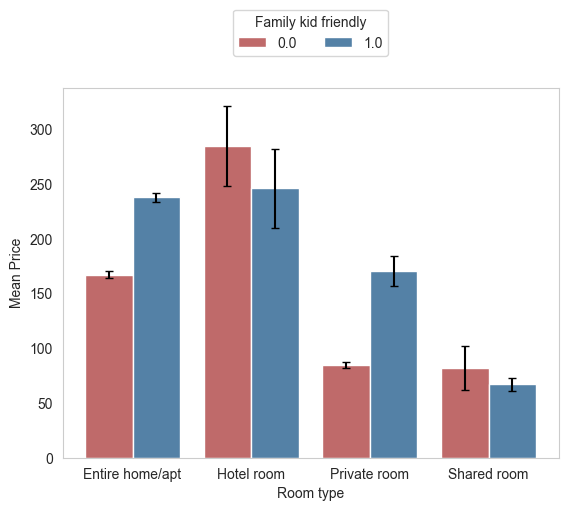

<module 'matplotlib.pyplot' from 'C:\\Users\\Acer\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [31]:
price_diff_by_variables(data,"room_type","Family","Room type", "Family kid friendly")

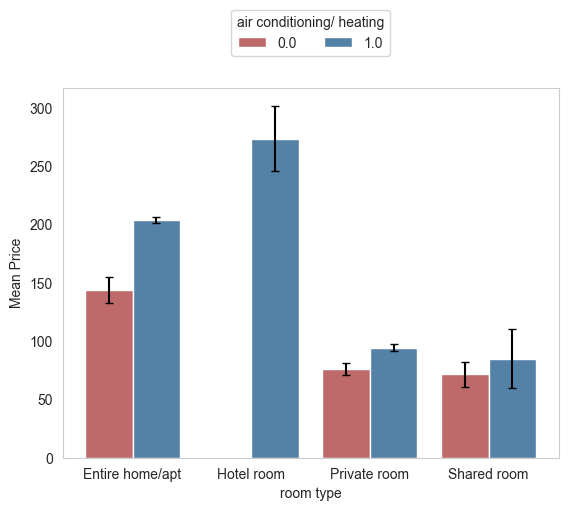

In [32]:
price_diff_by_variables(data, "room_type", "Heating_Cooling", "room type", "air conditioning/ heating");

In [33]:
X1 = ("room_type*instant_bookable", "room_type*Family")
X2 = ("room_type*in_center", "in_center*Kitchen", "room_type*Heating_Cooling")


basic_lev,
basic_add, 
reviews ,
host ,
nights ,
amenities ,
poly_lev 

In [34]:
modellev1="~ n_accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(reviews)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(reviews)+"+"+"+".join(host)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(nights)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(nights)+"+"+"+".join(amenities)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(nights)+"+"+"+".join(amenities)+"+"+"+".join(poly_lev)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(nights)+"+"+"+".join(amenities)+"+"+"+".join(X1)+"+"+"+".join(X2)



In [35]:
modellev8

'~n_accommodates+n_beds+room_type+n_days_since+flag_days_since+f_bathroom+distance+f_number_of_reviews+n_review_scores_rating+flag_review_scores_rating+host_acceptance_rate+host_is_superhost+host_has_profile_pic+host_identity_verified+n_minimum_nights+maximum_nights+Laundry+Essentials+Heating_Cooling+Kitchen+Outdoor+Workspace+Entertainment+Luxury+Internet+Parking+Family+room_type*instant_bookable+room_type*Family+room_type*in_center+in_center*Kitchen+room_type*Heating_Cooling'

# Regression with CV

In [36]:
smp_size = round(0.2 * data.shape[0])-1

In [37]:
smp_size

2863

In [38]:
# Set the seed to make results reproducable
np.random.seed(20020302)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
data_work, data_holdout = train_test_split(data, test_size = smp_size)
data_work.shape

(11456, 67)

In [41]:
data_holdout.shape

(2863, 67)

In [42]:
n_folds = 5

In [43]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse

k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [44]:
def cv_reg(formula, df, kfold, testdf, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(df):
        df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = df_train).fit()
        else:
            model = smf.ols(formula, data = df_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(df_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [df_train["price"], model.predict(df_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [df_test["price"], model.predict(df_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [45]:
f_columns = data.filter(like="nights", axis=1).columns.tolist()
print(f_columns)


['maximum_nights', 'n_minimum_nights', 'f_minimum_nights']


In [46]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, data, k, "HC0")]

In [47]:
summarize_cv(cv_list).map('{:,.3f}'.format)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,115.239,112.561,111.532,111.156,105.507,102.536,102.485,101.909
Fold2,110.817,108.389,107.251,106.767,102.685,99.679,99.570,98.791
Fold3,113.426,110.469,109.368,109.076,104.461,101.962,101.815,101.105
Fold4,116.769,114.229,112.574,112.190,107.687,104.148,104.091,103.145
Fold5,108.457,104.879,103.180,102.693,98.355,95.143,94.959,93.542
Average,112.941,110.105,108.781,108.376,103.739,100.694,100.584,99.698


In [48]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
data_rmse_levels = pd.DataFrame.from_dict(rmse_levels)
data_rmse_levels["nvars2"] = data_rmse_levels["nvars"] + 1

In [49]:
data_rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,112.941415,2
1,9,RMSE Training,110.105334,10
2,11,RMSE Training,108.781098,12
3,16,RMSE Training,108.376485,17
4,18,RMSE Training,103.739106,19
5,29,RMSE Training,100.693825,30
6,32,RMSE Training,100.583831,33
7,43,RMSE Training,99.698380,44
8,1,RMSE Test,112.800409,2
9,9,RMSE Test,111.862579,10


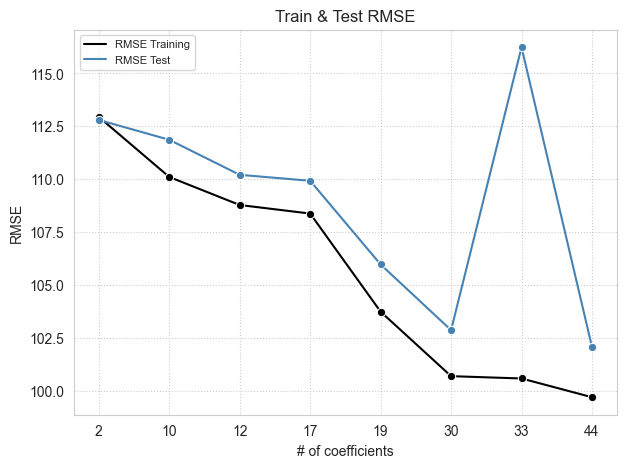

In [50]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    x = [str(x) for x in data_rmse_levels['nvars2']], 
    y = data_rmse_levels['value'], 
    hue = data_rmse_levels['var'], marker = 'o',
    palette = ['k', 'steelblue']
)
ax.set_title('Train & Test RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('# of coefficients')
ax.legend(fontsize = 8, title = None)
ax.grid(linestyle = ':')
plt.show();

In [51]:
data.price.describe()

count    14319.000000
mean       164.635729
std        133.469869
min         10.000000
25%         68.000000
50%        126.000000
75%        228.000000
max       1000.000000
Name: price, dtype: float64

## Lasso

In [52]:
predictors = basic_lev + reviews + host + nights + amenities + poly_lev
predictors_2 = basic_lev + reviews + host + nights + amenities + poly_lev + X1 + X2

In [53]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler

In [54]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [55]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, #> this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [56]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_work)

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
%%time
lasso_model_cv.fit(X_scaled, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-95.773 total time=   0.2s
[CV 2/5] END .....................alpha=0.05;, score=-103.821 total time=   0.0s
[CV 3/5] END .....................alpha=0.05;, score=-101.553 total time=   0.0s
[CV 4/5] END .....................alpha=0.05;, score=-106.644 total time=   0.0s
[CV 5/5] END ......................alpha=0.05;, score=-99.122 total time=   0.0s
[CV 1/5] END .......................alpha=0.1;, score=-95.776 total time=   0.0s
[CV 2/5] END ......................alpha=0.1;, score=-103.809 total time=   0.2s
[CV 3/5] END ......................alpha=0.1;, score=-101.537 total time=   0.2s
[CV 4/5] END ......................alpha=0.1;, score=-106.637 total time=   0.1s
[CV 5/5] END .......................alpha=0.1;, score=-99.127 total time=   0.0s
[CV 1/5] END ......................alpha=0.15;, score=-95.780 total time=   0.0s
[CV 2/5] END .....................alpha=0.15;, sc

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [59]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1)

In [60]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

101.3770113309149

## Random forest


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import math


In [62]:
y, X = dmatrices("price ~ " + " + ".join(predictors), data = data_work)

In [63]:
X.design_info.column_names

['Intercept',
 'room_type[T.Hotel room]',
 'room_type[T.Private room]',
 'room_type[T.Shared room]',
 'host_is_superhost[T.f]',
 'host_is_superhost[T.t]',
 'host_has_profile_pic[T.t]',
 'host_identity_verified[T.t]',
 'n_accommodates',
 'n_beds',
 'n_days_since',
 'flag_days_since',
 'f_bathroom',
 'distance',
 'f_number_of_reviews',
 'n_review_scores_rating',
 'flag_review_scores_rating',
 'host_acceptance_rate',
 'n_minimum_nights',
 'maximum_nights',
 'Laundry',
 'Essentials',
 'Heating_Cooling',
 'Kitchen',
 'Outdoor',
 'Workspace',
 'Entertainment',
 'Luxury',
 'Internet',
 'Parking',
 'Family',
 'n_accommodates2',
 'n_days_since2',
 'n_days_since3']

In [64]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 5.83.


In [65]:
rfr = RandomForestRegressor(random_state = 20020203)

In [66]:
tune_grid = {"max_features": [2, 4, 6, 8], "min_samples_leaf": [5, 10, 15]}

In [67]:
rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

In [68]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=2, min_samples_leaf=5;, score=-87.795 total time=   0.7s
[CV 2/5] END max_features=2, min_samples_leaf=5;, score=-94.266 total time=   0.7s
[CV 3/5] END max_features=2, min_samples_leaf=5;, score=-93.796 total time=   0.6s
[CV 4/5] END max_features=2, min_samples_leaf=5;, score=-94.976 total time=   0.6s
[CV 5/5] END max_features=2, min_samples_leaf=5;, score=-92.020 total time=   0.6s
[CV 1/5] END max_features=2, min_samples_leaf=10;, score=-90.999 total time=   0.5s
[CV 2/5] END max_features=2, min_samples_leaf=10;, score=-98.881 total time=   0.6s
[CV 3/5] END max_features=2, min_samples_leaf=10;, score=-97.061 total time=   0.5s
[CV 4/5] END max_features=2, min_samples_leaf=10;, score=-98.658 total time=   0.6s
[CV 5/5] END max_features=2, min_samples_leaf=10;, score=-95.444 total time=   0.5s
[CV 1/5] END max_features=2, min_samples_leaf=15;, score=-94.693 total time=   0.5s
[CV 2/5] END max_fea

In [69]:
rf_model.cv_results_

{'mean_fit_time': array([0.71954198, 0.61513672, 0.56918049, 1.34896502, 1.02961121,
        1.15555425, 1.63483753, 1.49619784, 1.95010157, 2.21078787,
        1.58208694, 1.4003377 ]),
 'std_fit_time': array([0.02424773, 0.03098822, 0.01933812, 0.26502639, 0.06874223,
        0.2221648 , 0.04220525, 0.13943765, 0.38371502, 0.31095254,
        0.04648117, 0.0394739 ]),
 'mean_score_time': array([0.03448944, 0.03161674, 0.02964377, 0.04442654, 0.03604784,
        0.03872738, 0.04299164, 0.04316983, 0.0726954 , 0.04885898,
        0.03620176, 0.03220801]),
 'std_score_time': array([0.00121795, 0.00220772, 0.00132064, 0.00753372, 0.00079721,
        0.00380578, 0.00272997, 0.00399395, 0.03553517, 0.01262625,
        0.00120205, 0.00284316]),
 'param_max_features': masked_array(data=[2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=obj

In [70]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [71]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results

,max features,min node size,RMSE
0,2,5,-92.570462
1,2,10,-96.208528
2,2,15,-98.865752
3,4,5,-85.768160
4,4,10,-89.237485
5,4,15,-91.046022
6,6,5,-83.521185
7,6,10,-86.821142
8,6,15,-88.648923
9,8,5,-82.694023


In [72]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1


min node size,5,10,15
max features,,,
2,92.57,96.21,98.87
4,85.77,89.24,91.05
6,83.52,86.82,88.65
8,82.69,85.58,87.39


In [73]:
rf_model.best_score_

-82.6940232310474

In [74]:
rf_model.best_estimator_

RandomForestRegressor(max_features=8, min_samples_leaf=5, random_state=20020203)

In [75]:
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors), data_holdout)
pred = rf_model.predict(X_h)

In [76]:
rf_rmse = mean_squared_error(y_h, pred, squared= False)
rf_rmse

81.35155557794923

In [77]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [78]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_minimum_nights,23.3%,23.3%
1,n_accommodates,12.1%,35.4%
2,n_accommodates2,11.7%,47.1%
3,distance,7.0%,54.1%
4,host_acceptance_rate,4.7%,58.9%
5,room_type[T.Private room],4.5%,63.4%
6,Family,4.0%,67.4%
7,n_beds,3.8%,71.2%
8,n_days_since3,3.3%,74.5%
9,n_review_scores_rating,3.1%,77.7%


In [79]:
%matplotlib inline

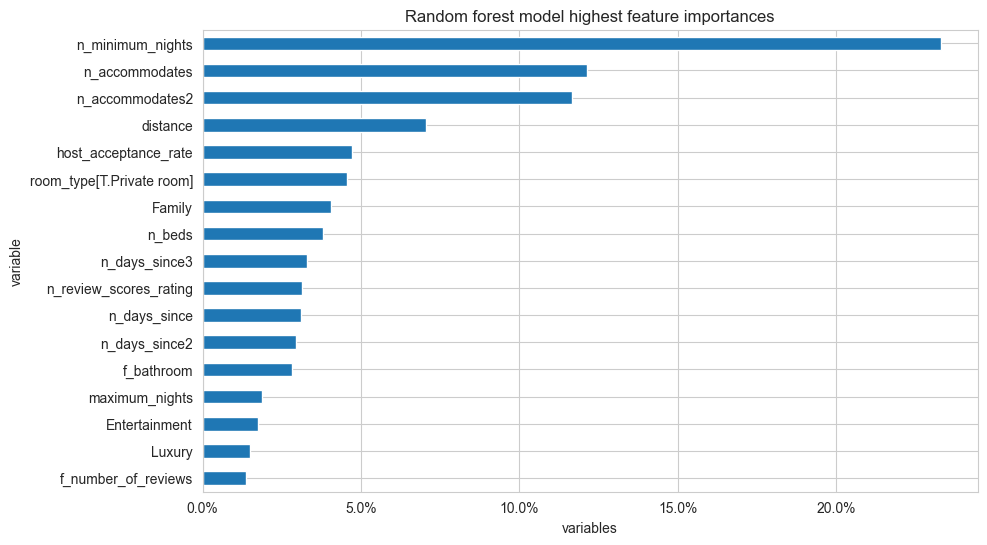

In [80]:
ax = df_var_imp[df_var_imp.imp > 0.01]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh',
          x = 'variable', 
          y = 'imp',
          figsize = (10,6), 
          grid = True,
          title = 'Random forest model highest feature importances',
          xlabel = 'variables', 
          legend = False)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Boosting with GBM

In [81]:
numerical_columns = ['n_accommodates', 'n_accommodates2', 'distance',
                    'n_minimum_nights', 'host_acceptance_rate', 'n_review_scores_rating',
                    'n_beds', 'n_days_since3', 'n_days_since2', 'n_days_since', 'maximum_nights']
categorical_columns = [col for col in predictors if col not in numerical_columns]

In [82]:
categorical_columns

['room_type',
 'flag_days_since',
 'f_bathroom',
 'f_number_of_reviews',
 'flag_review_scores_rating',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'Laundry',
 'Essentials',
 'Heating_Cooling',
 'Kitchen',
 'Outdoor',
 'Workspace',
 'Entertainment',
 'Luxury',
 'Internet',
 'Parking',
 'Family']

In [83]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10)

tune_grid = {"n_estimators": [30, 45], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [84]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

In [85]:
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [86]:
predictors = list(predictors)


In [87]:
%time
gbm_pipe.fit(data_work[predictors],data_work.price)

CPU times: total: 0 ns
Wall time: 0 ns
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  15.8s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type',
                                                   'flag_days_since',
                                                   'f_bathroom',
                                                   'f_number_of_reviews',
                                                   'flag_review_scores_rating',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'Laundry', 'Essentials',
                                                   'Heating_Cooling', 'Kitchen',
                                                   'Outdoor', 'Workspace',
                                                   'Entert...
                                                   'host_acceptance_rate',
                                                   'n_review_scores_rating',
                                                   'n_beds', 'n_days_since3',
                                                   'n_days_since2',
                                                   'n_days_since',
                                                   'maximum_nights'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [30, 45]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [88]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([1.60411158, 1.73935037, 1.71162248, 2.1894763 ]),
 'std_fit_time': array([0.17161019, 0.27906114, 0.07920261, 0.10350673]),
 'mean_score_time': array([0.01057196, 0.01156912, 0.01635642, 0.01583104]),
 'std_score_time': array([0.00173808, 0.00135278, 0.00286303, 0.00213797]),
 'param_max_depth': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[30, 45, 30, 45],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'n_estimators': 30},
  {'max_depth': 5, 'n_estimators': 45},
  {'max_depth': 10, 'n_estimators': 30},
  {'max_depth': 10, 'n_estimators': 45}],
 'split0_test_score': array([-83.29981793, -81.24642929, -78.89866231, -76.36186862]),
 'split1_test_score': array([-91.54738896, -89.02652358, -82.88751587, -80.93972782]),
 'split2_test_score': array([-91.451

In [89]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=45)

In [90]:
gbm_rmse = gbm_model_cv.best_score_*-1
gbm_rmse

79.9210823148813

                      Feature  Importance
46           n_minimum_nights    0.202907
43             n_accommodates    0.140071
45                   distance    0.070797
44            n_accommodates2    0.057583
47       host_acceptance_rate    0.050417
42                 Family_1.0    0.043906
0   room_type_Entire home/apt    0.034107
51              n_days_since2    0.031762
48     n_review_scores_rating    0.030647
52               n_days_since    0.029485


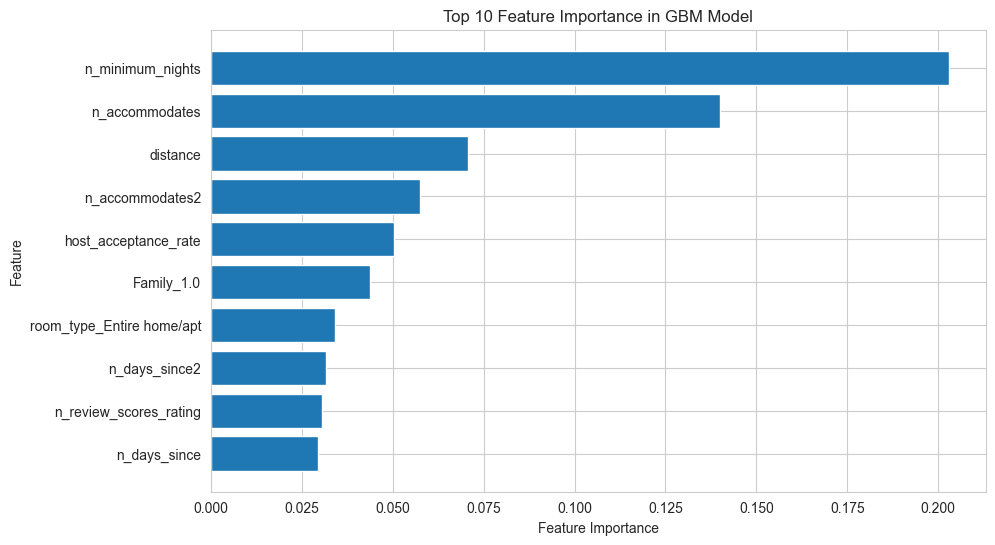

In [91]:
best_gbm_model = gbm_model_cv.best_estimator_

feature_importance = best_gbm_model.feature_importances_

# Step 3: Get the names of the transformed features
# Extract feature names after preprocessing
transformed_feature_names = (
    preprocessing.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist()  # One-hot encoded categorical features
    + numerical_columns  # Numerical features
)

# Step 4: Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importance
})

# Step 5: Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 6: Display the top N most important features
print(feature_importance_df.head(10))  # Adjust the number as needed

# Step 7: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])  # Plot top 10 features
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in GBM Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.grid(True)
plt.show()

### OLS RMSE

In [92]:
y, X = dmatrices("price ~ " + " + ".join(predictors), data = data_work)

ols_model = LinearRegression().fit(X,y)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

101.68991769941985

# Cart 

In [93]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_work)

In [95]:
cart_model = DecisionTreeRegressor(random_state=2039402)

In [96]:
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [97]:
ccp_alphas

array([ 0.00000000e+00, -3.94649591e-17,  1.99493200e-17, ...,
        4.73745289e+02,  2.20605707e+03,  4.23216899e+03])

In [98]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring="neg_root_mean_squared_error",
    verbose = 3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .ccp_alpha=0.009623777932960893;, score=-111.291 total time=   0.2s
[CV 2/5] END .ccp_alpha=0.009623777932960893;, score=-116.300 total time=   0.2s
[CV 3/5] END .ccp_alpha=0.009623777932960893;, score=-111.351 total time=   0.2s
[CV 4/5] END .ccp_alpha=0.009623777932960893;, score=-107.257 total time=   0.2s
[CV 5/5] END .ccp_alpha=0.009623777932960893;, score=-117.214 total time=   0.2s
[CV 1/5] END ccp_alpha=0.0011784217877093385;, score=-111.301 total time=   0.1s
[CV 2/5] END ccp_alpha=0.0011784217877093385;, score=-116.357 total time=   0.1s
[CV 3/5] END ccp_alpha=0.0011784217877093385;, score=-111.391 total time=   0.1s
[CV 4/5] END ccp_alpha=0.0011784217877093385;, score=-107.258 total time=   0.1s
[CV 5/5] END ccp_alpha=0.0011784217877093385;, score=-117.212 total time=   0.1s
[CV 1/5] END .....ccp_alpha=7.064910164550691;, score=-97.818 total time=   0.3s
[CV 2/5] END ....ccp_alpha=7.064910164550691;, s

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2039402),
                   param_distributions={'ccp_alpha': array([ 0.00000000e+00, -3.94649591e-17,  1.99493200e-17, ...,
        4.73745289e+02,  2.20605707e+03,  4.23216899e+03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [99]:
cart_model_cv.best_estimator_

DecisionTreeRegressor(ccp_alpha=7.064910164550691, random_state=2039402)

In [100]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

101.66853453725011

# #3. Comparison table and discussion

In [101]:
pd.DataFrame({'model': ['OLS', 'LASSO', 'Random Forest', 'GBM', 'Cart'],
              'CV RMSE': [ols_rmse, lasso_rmse,rf_rmse, gbm_rmse, cart_rmse]})

,model,CV RMSE
0,OLS,101.689918
1,LASSO,101.377011
2,Random Forest,81.351556
3,GBM,79.921082
4,Cart,101.668535


The GBM has the best performance with reasonable training time. Random Forest has a **relatively** good performance but is very slow to train. Lasso: **relatively** moderate performance but very fast to train. OLS has a moderate performance; time likely similar to LASSO. CART: worst performance with moderate training time.

# #4. Feature Importance for Random Forest and GBM

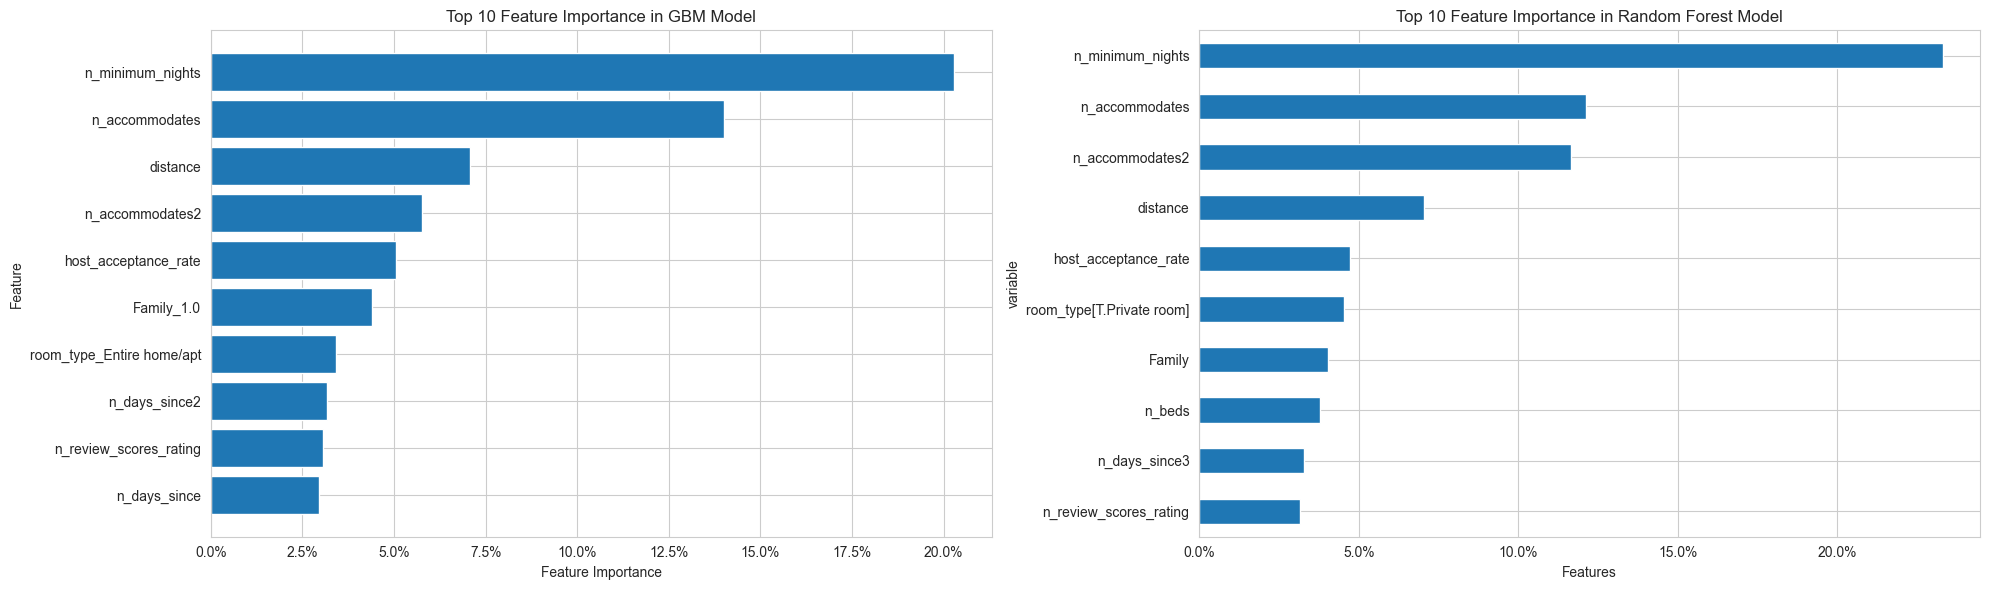

In [102]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot GBM Feature Importance
ax1.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
ax1.set_xlabel('Feature Importance')
ax1.set_ylabel('Feature')
ax1.set_title('Top 10 Feature Importance in GBM Model')
ax1.invert_yaxis()  # Invert y-axis to show the most important feature at the top
ax1.grid(True)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))  # Format x-axis as percentages

# Filter and sort Random Forest features for top 10
df_var_imp_top10 = df_var_imp[df_var_imp.imp > 0.01]\
    .sort_values(by='imp', ascending=False)\
    .head(10)  # Select top 10 features

# Plot Random Forest Feature Importance (Top 10)
df_var_imp_top10.plot(kind='barh',
                      x='variable',
                      y='imp',
                      ax=ax2,  # Use the second subplot
                      grid=True,
                      title='Top 10 Feature Importance in Random Forest Model',
                      xlabel='Features',
                      legend=False)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))  # Format x-axis as percentages
ax2.invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

The graphs reveal that **n_minimum_nights** and **n_accommodates** are the most important features in both the GBM and Random Forest models, indicating their strong influence on the target variable. The GBM model highlights **host_acceptance_rate** and **room_type_Entire home/apt** as significant, whereas the Random Forest model emphasizes **n_review_scores_rating** and **n_beds**. Both models agree on the importance of **distance**, suggesting it is a key predictor. However, the RF model assigns higher importance to some features (e.g., **n_beds**) compared to the GBM, reflecting differences in how each model captures feature interactions and nonlinearities.